In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os

from scipy import stats
from sklearn.discriminant_analysis import StandardScaler

2023-11-13 07:12:03.009897: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-13 07:12:03.045306: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-13 07:12:03.251973: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-13 07:12:03.253487: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 07:12:04.082985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
dados = pd.read_excel('../codigos/data/2019.xlsx')

In [19]:
# Calculando o desvio padrão e a média de cada coluna
std_dev = dados.iloc[:,1:].std()
mean = dados.iloc[:,1:].mean()

# Calculando o coeficiente de variação
cv = (std_dev / mean) * 100

# Ordenando os valores de coeficiente de variação em ordem crescente
sorted_cv = cv.sort_values()
sorted_cv

SANB11     4.474637
CMIG4      4.521171
VIVT3      4.617240
ITUB4      4.619709
EMBR3      4.713656
BBDC3      4.865882
BBDC4      4.892574
CPFE3      5.081461
PETR3      5.113370
ABEV3      5.130422
ITSA4      5.607895
BBAS3      5.662059
TAEE11     5.847997
PETR4      6.064897
VALE3      6.070010
EGIE3      6.378217
ENBR3      7.702088
BRAP4      7.709177
TIMS3      7.828194
ENGI11     8.631387
ELET6      8.968866
MULT3      9.225741
GOAU4      9.253820
HYPE3      9.311758
USIM5     10.308946
GGBR4     10.331301
EQTL3     10.550143
ELET3     10.559928
LREN3     11.567146
FLRY3     11.872620
SBSP3     13.242188
CCRO3     13.757272
RENT3     14.039829
MRVE3     14.627790
CSAN3     15.251315
UGPA3     15.409081
CSNA3     16.301750
B3SA3     16.876979
CIEL3     17.100198
YDUQ3     17.284784
GOLL4     17.948956
BRFS3     19.450469
WEGE3     19.560503
CPLE6     20.145432
CYRE3     21.218235
RADL3     21.801590
TOTS3     23.119479
BRKM5     25.218369
MRFG3     26.818526
JBSS3     26.863095


In [2]:
dados_fixo = pd.read_excel('./resultados_test_fixo.xlsx')
dados_deslizante = pd.read_excel('./resultados_test_deslizante.xlsx')

In [ ]:
# Function to plot multiple bar charts for all assets with logarithmic scale in a grid layout

def plot_all_assets_bar_log(data_fixo, data_deslizante, ncols=2):
    n_assets = len(data_fixo)
    n_rows = int(np.ceil(n_assets))
    fig, axes = plt.subplots(n_rows, ncols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()  # Flatten the grid to easily iterate over it

    

    for i in range(0, len(data_fixo['Ativos'])):
        asset = data_fixo['Ativos'][i]
       
        ax = axes[2*i]
        bar_width = 0.2
        months = list(range(1, 13))  # Months from January to December
        index = range(len(months))

        

        for j, metric in enumerate(['Individual', 'Agrupado', 'Media']):
            values = []
            for month in months:
                column_name = f"{month} {metric}"
                # Applying logarithm to the values to improve visualization, adding a small constant to avoid log(0)
                values.append(data_fixo.loc[data_fixo['Ativos'] == asset, column_name].values[0])
            ax.bar([p + bar_width * j for p in index], values, width=bar_width, label=metric)



        ax.set_title(f"Mape: {asset}")
        ax.set_xlabel('Mes')
        ax.set_ylabel('Valor')
        ax.set_xticks([p + bar_width for p in index])
        ax.set_xticklabels(months)
        ax.legend()
       
        ax = axes[2*i + 1]
        bar_width = 0.2
        months = list(range(1, 13))  # Months from January to December
        index = range(len(months))

        

        for j, metric in enumerate(['Individual', 'Agrupado', 'Media']):
            values = []
            for month in months:
                column_name = f"{month} {metric}"
                # Applying logarithm to the values to improve visualization, adding a small constant to avoid log(0)
                values.append(data_deslizante.loc[data_deslizante['Ativos'] == asset, column_name].values[0])
            ax.bar([p + bar_width * j for p in index], values, width=bar_width, label=metric)

        

        ax.set_title(f"Mape: {asset}")
        ax.set_xlabel('Mes')
        ax.set_ylabel('Valor')
        ax.set_xticks([p + bar_width for p in index])
        ax.set_xticklabels(months)
        ax.legend()


    

    # Remove any empty subplots
    for i in range(n_assets, len(axes)):
        fig.delaxes(axes[i])

    
    plt.tight_layout()
    plt.show()



# Plotting the bar charts with logarithmic scale for all assets in a 2-column grid
plot_all_assets_bar_log(dados_fixo, dados_deslizante, ncols=2)

In [4]:
dados_novo = pd.DataFrame(data={
  "Ativos": dados_fixo['Ativos'],
  
  "1 Individual fixo": dados_fixo['1 Individual'], "1 Individual deslizante":  dados_deslizante['1 Individual'],
  "1 Agrupado fixo":   dados_fixo['1 Agrupado'],   "1 Agrupado deslizante":    dados_deslizante['1 Agrupado'],
  "1 Media fixo":      dados_fixo['1 Media'],      "1 Media deslizante":       dados_deslizante['1 Media'],
  
  "2 Individual fixo": dados_fixo['2 Individual'], "2 Individual deslizante":  dados_deslizante['2 Individual'],
  "2 Agrupado fixo":   dados_fixo['2 Agrupado'],   "2 Agrupado deslizante":    dados_deslizante['2 Agrupado'],
  "2 Media fixo":      dados_fixo['2 Media'],      "2 Media deslizante":       dados_deslizante['2 Media'],
  
  "3 Individual fixo": dados_fixo['3 Individual'], "3 Individual deslizante":  dados_deslizante['3 Individual'],
  "3 Agrupado fixo":   dados_fixo['3 Agrupado'],   "3 Agrupado deslizante":    dados_deslizante['3 Agrupado'],
  "3 Media fixo":      dados_fixo['3 Media'],      "3 Media deslizante":       dados_deslizante['3 Media'],
  
  "4 Individual fixo": dados_fixo['4 Individual'], "4 Individual deslizante":  dados_deslizante['4 Individual'],
  "4 Agrupado fixo":   dados_fixo['4 Agrupado'],   "4 Agrupado deslizante":    dados_deslizante['4 Agrupado'],
  "4 Media fixo":      dados_fixo['4 Media'],      "4 Media deslizante":       dados_deslizante['4 Media'],
  
  "5 Individual fixo": dados_fixo['5 Individual'], "5 Individual deslizante":  dados_deslizante['5 Individual'],
  "5 Agrupado fixo":   dados_fixo['5 Agrupado'],   "5 Agrupado deslizante":    dados_deslizante['5 Agrupado'],
  "5 Media fixo":      dados_fixo['5 Media'],      "5 Media deslizante":       dados_deslizante['5 Media'],
  
  "6 Individual fixo": dados_fixo['6 Individual'], "6 Individual deslizante":  dados_deslizante['6 Individual'],
  "6 Agrupado fixo":   dados_fixo['6 Agrupado'],   "6 Agrupado deslizante":    dados_deslizante['6 Agrupado'],
  "6 Media fixo":      dados_fixo['6 Media'],      "6 Media deslizante":       dados_deslizante['6 Media'],
  
  "7 Individual fixo": dados_fixo['7 Individual'], "7 Individual deslizante":  dados_deslizante['7 Individual'],
  "7 Agrupado fixo":   dados_fixo['7 Agrupado'],   "7 Agrupado deslizante":    dados_deslizante['7 Agrupado'],
  "7 Media fixo":      dados_fixo['7 Media'],      "7 Media deslizante":       dados_deslizante['7 Media'],
  
  "8 Individual fixo": dados_fixo['8 Individual'], "8 Individual deslizante":  dados_deslizante['8 Individual'],
  "8 Agrupado fixo":   dados_fixo['8 Agrupado'],   "8 Agrupado deslizante":    dados_deslizante['8 Agrupado'],
  "8 Media fixo":      dados_fixo['8 Media'],      "8 Media deslizante":       dados_deslizante['8 Media'],
  
  "9 Individual fixo": dados_fixo['9 Individual'], "9 Individual deslizante":  dados_deslizante['9 Individual'],
  "9 Agrupado fixo":   dados_fixo['9 Agrupado'],   "9 Agrupado deslizante":    dados_deslizante['9 Agrupado'],
  "9 Media fixo":      dados_fixo['9 Media'],      "9 Media deslizante":       dados_deslizante['9 Media'],
  
  "10 Individual fixo": dados_fixo['10 Individual'], "10 Individual deslizante":  dados_deslizante['10 Individual'],
  "10 Agrupado fixo":   dados_fixo['10 Agrupado'],   "10 Agrupado deslizante":    dados_deslizante['10 Agrupado'],
  "10 Media fixo":      dados_fixo['10 Media'],      "10 Media deslizante":       dados_deslizante['10 Media'],
  
  "11 Individual fixo": dados_fixo['11 Individual'], "11 Individual deslizante":  dados_deslizante['11 Individual'],
  "11 Agrupado fixo":   dados_fixo['11 Agrupado'],   "11 Agrupado deslizante":    dados_deslizante['11 Agrupado'],
  "11 Media fixo":      dados_fixo['11 Media'],      "11 Media deslizante":       dados_deslizante['11 Media'],
  
  "12 Individual fixo": dados_fixo['12 Individual'], "12 Individual deslizante":  dados_deslizante['12 Individual'],
  "12 Agrupado fixo":   dados_fixo['12 Agrupado'],   "12 Agrupado deslizante":    dados_deslizante['12 Agrupado'],
  "12 Media fixo":      dados_fixo['12 Media'],      "12 Media deslizante":       dados_deslizante['12 Media']
})

In [227]:
dados_novo.to_excel('Resultado_fixo_deslizante.xlsx', index=False)

NameError: name 'dados_novo' is not defined

In [ ]:
def plot_all_assets_bar_log(data_fixo, data_deslizante, ncols=2):
    n_assets = len(data_fixo)
    n_rows = int(np.ceil(n_assets))
    fig, axes = plt.subplots(n_rows, ncols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()  # Flatten the grid to easily iterate over it

    

    for i in range(0, len(data_fixo['Ativos'])):
        asset = data_fixo['Ativos'][i]
       
        ax = axes[2*i]
        bar_width = 0.2
        months = list(range(1, 13))  # Months from January to December
        index = range(len(months))

        

        for j, metric in enumerate(['Individual', 'Agrupado', 'Media']):
            values = []
            for month in months:
                column_name = f"{month} {metric}"
                # Applying logarithm to the values to improve visualization, adding a small constant to avoid log(0)
                values.append(data_fixo.loc[data_fixo['Ativos'] == asset, column_name].values[0])
            ax.bar([p + bar_width * j for p in index], values, width=bar_width, label=metric)



        ax.set_title(f"Mape: {asset}")
        ax.set_xlabel('Mes')
        ax.set_ylabel('Valor')
        ax.set_xticks([p + bar_width for p in index])
        ax.set_xticklabels(months)
        ax.legend()
       
        ax = axes[2*i + 1]
        bar_width = 0.2
        months = list(range(1, 13))  # Months from January to December
        index = range(len(months))

        

        for j, metric in enumerate(['Individual', 'Agrupado', 'Media']):
            values = []
            for month in months:
                column_name = f"{month} {metric}"
                # Applying logarithm to the values to improve visualization, adding a small constant to avoid log(0)
                values.append(data_deslizante.loc[data_deslizante['Ativos'] == asset, column_name].values[0])
            ax.bar([p + bar_width * j for p in index], values, width=bar_width, label=metric)

        

        ax.set_title(f"Mape: {asset}")
        ax.set_xlabel('Mes')
        ax.set_ylabel('Valor')
        ax.set_xticks([p + bar_width for p in index])
        ax.set_xticklabels(months)
        ax.legend()


    

    # Remove any empty subplots
    for i in range(n_assets, len(axes)):
        fig.delaxes(axes[i])

    
    plt.tight_layout()
    plt.show()



# Plotting the bar charts with logarithmic scale for all assets in a 2-column grid
plot_all_assets_bar_log(dados_fixo, dados_deslizante, ncols=2)

In [41]:
dados_novo.columns

Index(['Ativos', '1 Individual fixo', '1 Individual deslizante',
       '1 Agrupado fixo', '1 Agrupado deslizante', '1 Media fixo',
       '1 Media deslizante', '2 Individual fixo', '2 Individual deslizante',
       '2 Agrupado fixo', '2 Agrupado deslizante', '2 Media fixo',
       '2 Media deslizante', '3 Individual fixo', '3 Individual deslizante',
       '3 Agrupado fixo', '3 Agrupado deslizante', '3 Media fixo',
       '3 Media deslizante', '4 Individual fixo', '4 Individual deslizante',
       '4 Agrupado fixo', '4 Agrupado deslizante', '4 Media fixo',
       '4 Media deslizante', '5 Individual fixo', '5 Individual deslizante',
       '5 Agrupado fixo', '5 Agrupado deslizante', '5 Media fixo',
       '5 Media deslizante', '6 Individual fixo', '6 Individual deslizante',
       '6 Agrupado fixo', '6 Agrupado deslizante', '6 Media fixo',
       '6 Media deslizante', '7 Individual fixo', '7 Individual deslizante',
       '7 Agrupado fixo', '7 Agrupado deslizante', '7 Media fixo',
    

In [43]:
dados_novo.head()

,Ativos,1 Individual fixo,1 Individual deslizante,1 Agrupado fixo,1 Agrupado deslizante,1 Media fixo,1 Media deslizante,2 Individual fixo,2 Individual deslizante,2 Agrupado fixo,...,11 Agrupado fixo,11 Agrupado deslizante,11 Media fixo,11 Media deslizante,12 Individual fixo,12 Individual deslizante,12 Agrupado fixo,12 Agrupado deslizante,12 Media fixo,12 Media deslizante
0,ABEV3,3.181050,1.978033,1.226508,1.702243,0.901485,1.598882,1.087269,1.524238,1.157799,...,3.025232,3.212881,4.753246,2.500480,0.360926,0.276175,0.420764,0.233452,0.278065,0.390651
1,B3SA3,0.302407,0.615839,0.289512,1.411510,0.379135,0.544821,0.178384,0.196360,0.141082,...,0.087927,0.286796,0.118885,0.066236,0.137200,0.145590,0.107183,0.130451,0.158971,0.161130
2,BBAS3,3.673927,7.772249,2.598941,4.988360,4.759731,7.945591,0.377449,0.400900,0.360815,...,0.363076,0.324363,0.534274,0.579604,1.252588,0.739528,0.898277,1.370804,1.357877,0.788071
3,BBDC3,2.665606,2.808706,1.869680,1.770609,3.211284,3.606103,0.545474,0.531837,0.620229,...,1.714031,1.416710,1.947730,1.878200,1.067534,0.758598,1.159692,0.707540,1.305655,1.451855
4,BBDC4,1.478824,7.925585,1.320355,3.632182,1.839364,6.066896,0.433904,0.313363,0.351506,...,2.736738,1.897754,2.492905,2.298974,0.490561,0.586423,0.578176,0.569089,0.705110,0.686222


In [58]:

dados_novo.iloc[0][[1,7,13,19,25,31,37,43,49,55,61,67]]
dados_novo.iloc[0][[2,8,14,20,26,32,38,44,50,56,62,68]]
dados_novo.iloc[0][[3,9,15,21,27,33,39,45,51,57,63,69]]
dados_novo.iloc[0][[4,10,16,22,28,34,40,46,52,58,64,70]]
dados_novo.iloc[0][[5,11,17,23,29,35,41,47,53,59,65,71]]
dados_novo.iloc[0][[6,12,18,24,30,36,42,48,54,60,66,72]]

1 Media deslizante     1.598882
2 Media deslizante     1.909466
3 Media deslizante     0.246735
4 Media deslizante     0.502479
5 Media deslizante     1.863139
6 Media deslizante      3.32291
7 Media deslizante     1.768647
8 Media deslizante     1.348891
9 Media deslizante     0.208379
10 Media deslizante    0.715839
11 Media deslizante     2.50048
12 Media deslizante    0.390651
Name: 0, dtype: object

In [82]:
dados_novo.iloc[0]

Ativos                         ABEV3
1 Individual fixo            3.18105
1 Individual deslizante     1.978033
1 Agrupado fixo             1.226508
1 Agrupado deslizante       1.702243
                              ...   
12 Individual deslizante    0.276175
12 Agrupado fixo            0.420764
12 Agrupado deslizante      0.233452
12 Media fixo               0.278065
12 Media deslizante         0.390651
Name: 0, Length: 73, dtype: object

In [87]:

# Definir as classes e métricas
classes = ['Janeiro', 'Fevereiro', 'Março','Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
Individual_fixo = list(dados_novo.iloc[0][[1,7,13,19,25,31,37,43,49,55,61,67]])
Agrupado_fixo = list(dados_novo.iloc[0][[3,9,15,21,27,33,39,45,51,57,63,69]])
Media_fixo = list(dados_novo.iloc[0][[5,11,17,23,29,35,41,47,53,59,65,71]])

Individual_deslizante = list(dados_novo.iloc[0][[2,8,14,20,26,32,38,44,50,56,62,68]])
Agrupado_deslizante = list(dados_novo.iloc[0][[4,10,16,22,28,34,40,46,52,58,64,70]])
Media_deslizante = list(dados_novo.iloc[0][[6,12,18,24,30,36,42,48,54,60,66,72]])

# Definir a largura das barras e a posição das classes no eixo x
barWidth = 0.1

rif = np.arange(len(classes))
rid = [x + barWidth for x in rif]
raf = [x + barWidth + 0.05 for x in rid]
rad = [x + barWidth for x in raf]
rmf = [x + barWidth + 0.05 for x in rad]
rmd = [x + barWidth for x in rmf]

# Fazer o gráfico
plt.subplots(figsize=(15, 6))

plt.bar(rif, Individual_fixo, color='#18098f', width=barWidth, edgecolor='grey', label='Individual Fixo')
plt.bar(rid, Individual_deslizante, color='#66b4d4', width=barWidth, edgecolor='grey', label='Individual Deslizante')

plt.bar(raf, Agrupado_fixo, color='#9e081c', width=barWidth, edgecolor='grey', label='Agrupado Fixo')
plt.bar(rad, Agrupado_deslizante, color='#a87981', width=barWidth, edgecolor='grey', label='Agrupado Deslizante')

plt.bar(rmf, Media_fixo, color='#216e05', width=barWidth, edgecolor='grey', label='Media Fixo')
plt.bar(rmd, Media_deslizante, color='#97c985', width=barWidth, edgecolor='grey', label='Media Deslizante')

# Adicionar rótulos às barras
plt.xlabel('Meses', fontweight='bold')
plt.xticks([r + barWidth + 0.2 for r in range(len(classes))], classes)

plt.ylabel('Erro (Mape)', fontweight='bold')

# Adicionar a legenda
plt.legend()

# # Mostrar o gráfico
# plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Número de gráficos
n_plots = len(dados_novo)


# Criar figura e eixos (50 linhas, 1 coluna)
fig, axs = plt.subplots(n_plots, 1, figsize=(15, 4 * n_plots))

# Loop para preencher cada subplot
for ax, i in zip(axs, range(n_plots)):

    classes = ['Janeiro', 'Fevereiro', 'Março','Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
    Individual_fixo = list(dados_novo.iloc[i][[1,7,13,19,25,31,37,43,49,55,61,67]])
    Agrupado_fixo = list(dados_novo.iloc[i][[3,9,15,21,27,33,39,45,51,57,63,69]])
    Media_fixo = list(dados_novo.iloc[i][[5,11,17,23,29,35,41,47,53,59,65,71]])

    Individual_deslizante = list(dados_novo.iloc[i][[2,8,14,20,26,32,38,44,50,56,62,68]])
    Agrupado_deslizante = list(dados_novo.iloc[i][[4,10,16,22,28,34,40,46,52,58,64,70]])
    Media_deslizante = list(dados_novo.iloc[i][[6,12,18,24,30,36,42,48,54,60,66,72]])
    
    # Posições das barras
    barWidth = 0.1
    rif = np.arange(len(classes))
    rid = [x + barWidth for x in rif]
    raf = [x + barWidth + 0.05 for x in rid]
    rad = [x + barWidth for x in raf]
    rmf = [x + barWidth + 0.05 for x in rad]
    rmd = [x + barWidth for x in rmf]
    
    # Fazer o gráfico
    ax.bar(rif, Individual_fixo, color='#18098f', width=barWidth, edgecolor='grey', label='Individual Fixo')
    ax.bar(rid, Individual_deslizante, color='#66b4d4', width=barWidth, edgecolor='grey', label='Individual Deslizante')

    ax.bar(raf, Agrupado_fixo, color='#9e081c', width=barWidth, edgecolor='grey', label='Agrupado Fixo')
    ax.bar(rad, Agrupado_deslizante, color='#a87981', width=barWidth, edgecolor='grey', label='Agrupado Deslizante')

    ax.bar(rmf, Media_fixo, color='#216e05', width=barWidth, edgecolor='grey', label='Media Fixo')
    ax.bar(rmd, Media_deslizante, color='#97c985', width=barWidth, edgecolor='grey', label='Media Deslizante')


    # Adicionar rótulos às barras
    ax.set_xlabel('Meses', fontweight='bold')
    ax.set_xticks([r + barWidth for r in range(len(classes))])
    ax.set_xticklabels(classes)
    ax.set_ylabel('Erro (Mape)', fontweight='bold')
    
    ax.set_title(f'{dados_novo.iloc[i][0]}', fontweight='bold')
    
    ax.legend()

# Ajustar o layout
plt.tight_layout()

# Mostrar os gráficos
plt.show()


In [102]:
dados_novo.iloc[i][[1,7,13,19,25,31,37,43,49,55,61,67]].mean()

0.5983966495994667

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Número de gráficos
n_plots = len(dados_novo)


# Criar figura e eixos (50 linhas, 1 coluna)
fig, axs = plt.subplots(n_plots, 1, figsize=(6, 3 * n_plots))

# Loop para preencher cada subplot
for ax, i in zip(axs, range(n_plots)):

    classes = ['Fixo', 'Deslizante']
    
    Individual = [dados_novo.iloc[i][[1,7,13,19,25,31,37,43,49,55,61,67]].mean(), dados_novo.iloc[i][[2,8,14,20,26,32,38,44,50,56,62,68]].mean()]
    Agrupado = [dados_novo.iloc[i][[3,9,15,21,27,33,39,45,51,57,63,69]].mean(), dados_novo.iloc[i][[4,10,16,22,28,34,40,46,52,58,64,70]].mean()]
    Media = [dados_novo.iloc[i][[5,11,17,23,29,35,41,47,53,59,65,71]].mean(), dados_novo.iloc[i][[6,12,18,24,30,36,42,48,54,60,66,72]].mean()]

    
    # Posições das barras
    barWidth = 0.1
    ri = [0,0.4]
    ra = [x + barWidth  for x in ri]
    rm = [x + barWidth for x in ra]
    
    # Fazer o gráfico
    ax.bar(ri, Individual, color='#18098f', width=barWidth, edgecolor='grey', label='Individual')

    ax.bar(ra, Agrupado, color='#9e081c', width=barWidth, edgecolor='grey', label='Agrupado')

    ax.bar(rm, Media, color='#216e05', width=barWidth, edgecolor='grey', label='Media')


    # Adicionar rótulos às barras
    ax.set_xlabel('Abordagem', fontweight='bold')
    ax.set_xticks([r + barWidth for r in ri])
    ax.set_xticklabels(classes)
    ax.set_ylabel('Média anual do erro', fontweight='bold')
    
    # ax.set_xticks(np.arange(0, 2, 2))
    
    ax.set_title(f'{dados_novo.iloc[i][0]}', fontweight='bold')
    
    ax.legend()
    ax.legend(loc=(1, 0.7))
    
# Ajustar o layout
plt.tight_layout()

# Mostrar os gráficos
plt.show()


NameError: name 'dados_novo' is not defined

## Resultados Clusters

In [228]:
## Grafico dos erros por cluster
def label_cluster_plot (cluster, bottom):
    classificacao = pd.read_excel('../codigos/resultados/2019/classes_nova.xlsx')
    cluster_series = classificacao.query(f'classes=={cluster}')
    n_cluster = len(cluster_series['ativos'])
    
    ax = fig.add_axes([0, bottom, 0.2, 0.18 - 0.015])
    ax.text(0.5, 0.6, f'Cluster {i}', ha='center', va='center', fontsize=20, fontweight='bold')
    ax.text(0.5, 0.4, f'{n_cluster} Séries', ha='center', va='center', fontsize=18)
    ax.axis('off')
    return ax



In [311]:
## Grafico das series por cluster
def series_cluster_plot (cluster, bottom):
  dados = pd.read_excel('../codigos/data/2019_t.xlsx')
  classificacao = pd.read_excel('../codigos/resultados/2019/classes_nova.xlsx')
  cluster_series = classificacao.query(f'classes=={cluster}')

  
  ax = fig.add_axes([0.2, bottom, 0.40, 0.18 - 0.015])
  
  ax.plot(dados[cluster_series['ativos']], label=cluster_series['ativos']);
  ax.set_title('Preço de fechamento transformado das empresas', fontweight='bold')
  # ax.set_xlabel('x')
  # ax.set_ylabel('y')
  ax.legend()
  return ax

In [312]:
import matplotlib.patches as patches

def grafico_erro_cluster(dados, cluster, bottom):

    classificacao = pd.read_excel('../codigos/resultados/2019/classes_nova.xlsx')
    cluster_series = classificacao.query(f'classes=={cluster}')


    # Parâmetros do gráfico
    num_ativos = len(dados)
    num_features = len(dados.columns)
    barWidth = 0.1
    features = dados.columns

    # Criando o plot
    ax = fig.add_axes([0.65, bottom, 0.35, 0.18 - 0.015])
    # fig, ax = plt.subplots(figsize=(7, 5))

    # Definindo a posição das barras
    r = np.arange(len(dados.index))

    # Plotando as barras para cada ativo
    r2=[0]
    tick_positions = []

    resultado_cluster = dados[dados['Ativos'].isin(cluster_series['ativos'])]
    for i, ativo in enumerate(resultado_cluster['Ativos']):
        
        resultados_ativo = resultado_cluster.query(f'Ativos=="{ativo}"')
        
        
        
        Individual = [resultados_ativo.iloc[0][[1,7,13,19,25,31,37,43,49,55,61,67]].mean(), resultados_ativo.iloc[0][[2,8,14,20,26,32,38,44,50,56,62,68]].mean()]
        Agrupado = [resultados_ativo.iloc[0][[3,9,15,21,27,33,39,45,51,57,63,69]].mean(), resultados_ativo.iloc[0][[4,10,16,22,28,34,40,46,52,58,64,70]].mean()]
        Media = [resultados_ativo.iloc[0][[5,11,17,23,29,35,41,47,53,59,65,71]].mean(), resultados_ativo.iloc[0][[6,12,18,24,30,36,42,48,54,60,66,72]].mean()]


        first_group = [Individual[0], Agrupado[0], Media[0]]
        second_group = [Individual[1], Agrupado[1], Media[1]]
        
        inicio = 0 if i == 0 else 0.4
        r1 = [r2[-1] + inicio + x for x in np.arange(0,0.3,0.1)]
        r2 = [r1[-3] + x +0.1 for x in np.arange(0.3,0.6,0.1)]


        ax.bar(r1, first_group, color=['#8793a6', '#546973', '#2e3148'], width=barWidth, edgecolor='#f7f7f7', hatch='//')
        
        ax.bar(r2, second_group, color=['#8793a6', '#546973', '#2e3148'], width=barWidth, edgecolor='#f7f7f7')
        
        # Calcular as posições dos ticks com base na posição das barras
        tick_positions.append((r1[0] + r2[-1]) / 2)
        
    # Definir as posições dos ticks
    ax.set_xticks(tick_positions)

    # Definir os rótulos dos ticks
    ax.set_xticklabels(resultado_cluster['Ativos'])

    handle3 = patches.Rectangle((0, 0), 1, 1, facecolor="#8793a6", edgecolor="#f7f7f7", label="Individual")
    handle4 = patches.Rectangle((0, 0), 1, 1, facecolor="#546973", edgecolor="#f7f7f7", label="Agrupado")
    handle5 = patches.Rectangle((0, 0), 1, 1, facecolor="#2e3148", edgecolor="#f7f7f7", label="Média")

    legend2 = ax.legend(handles=[handle3, handle4, handle5], bbox_to_anchor=(1.2, 0.7), title='Modelo')
    ax.add_artist(legend2)


    # Criando handles para as legendas
    handle1 = patches.Rectangle((0, 0), 1, 1, facecolor="#f7f7f7", edgecolor="gray", hatch="//", label="Fixo")
    handle2 = patches.Rectangle((0, 0), 1, 1, facecolor="#f7f7f7", edgecolor="gray", label="Deslizante")
    ax.legend(handles=[handle1, handle2], bbox_to_anchor=(1.2, 1), title='Tipo de janela')


    # Configurando o título e rótulos dos eixos
    ax.set_title('Erro anual por empresa', fontweight='bold')
    ax.set_xlabel('Ativos', fontweight='bold')
    ax.set_ylabel('MAPE', fontweight='bold')

    # Exibindo o gráfico
    plt.tight_layout()
    return ax


/tmp/ipykernel_13328/1413860713.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_13328/1413860713.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_13328/1413860713.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_13328/1413860713.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_13328/1413860713.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_13328/1413860713.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results mig

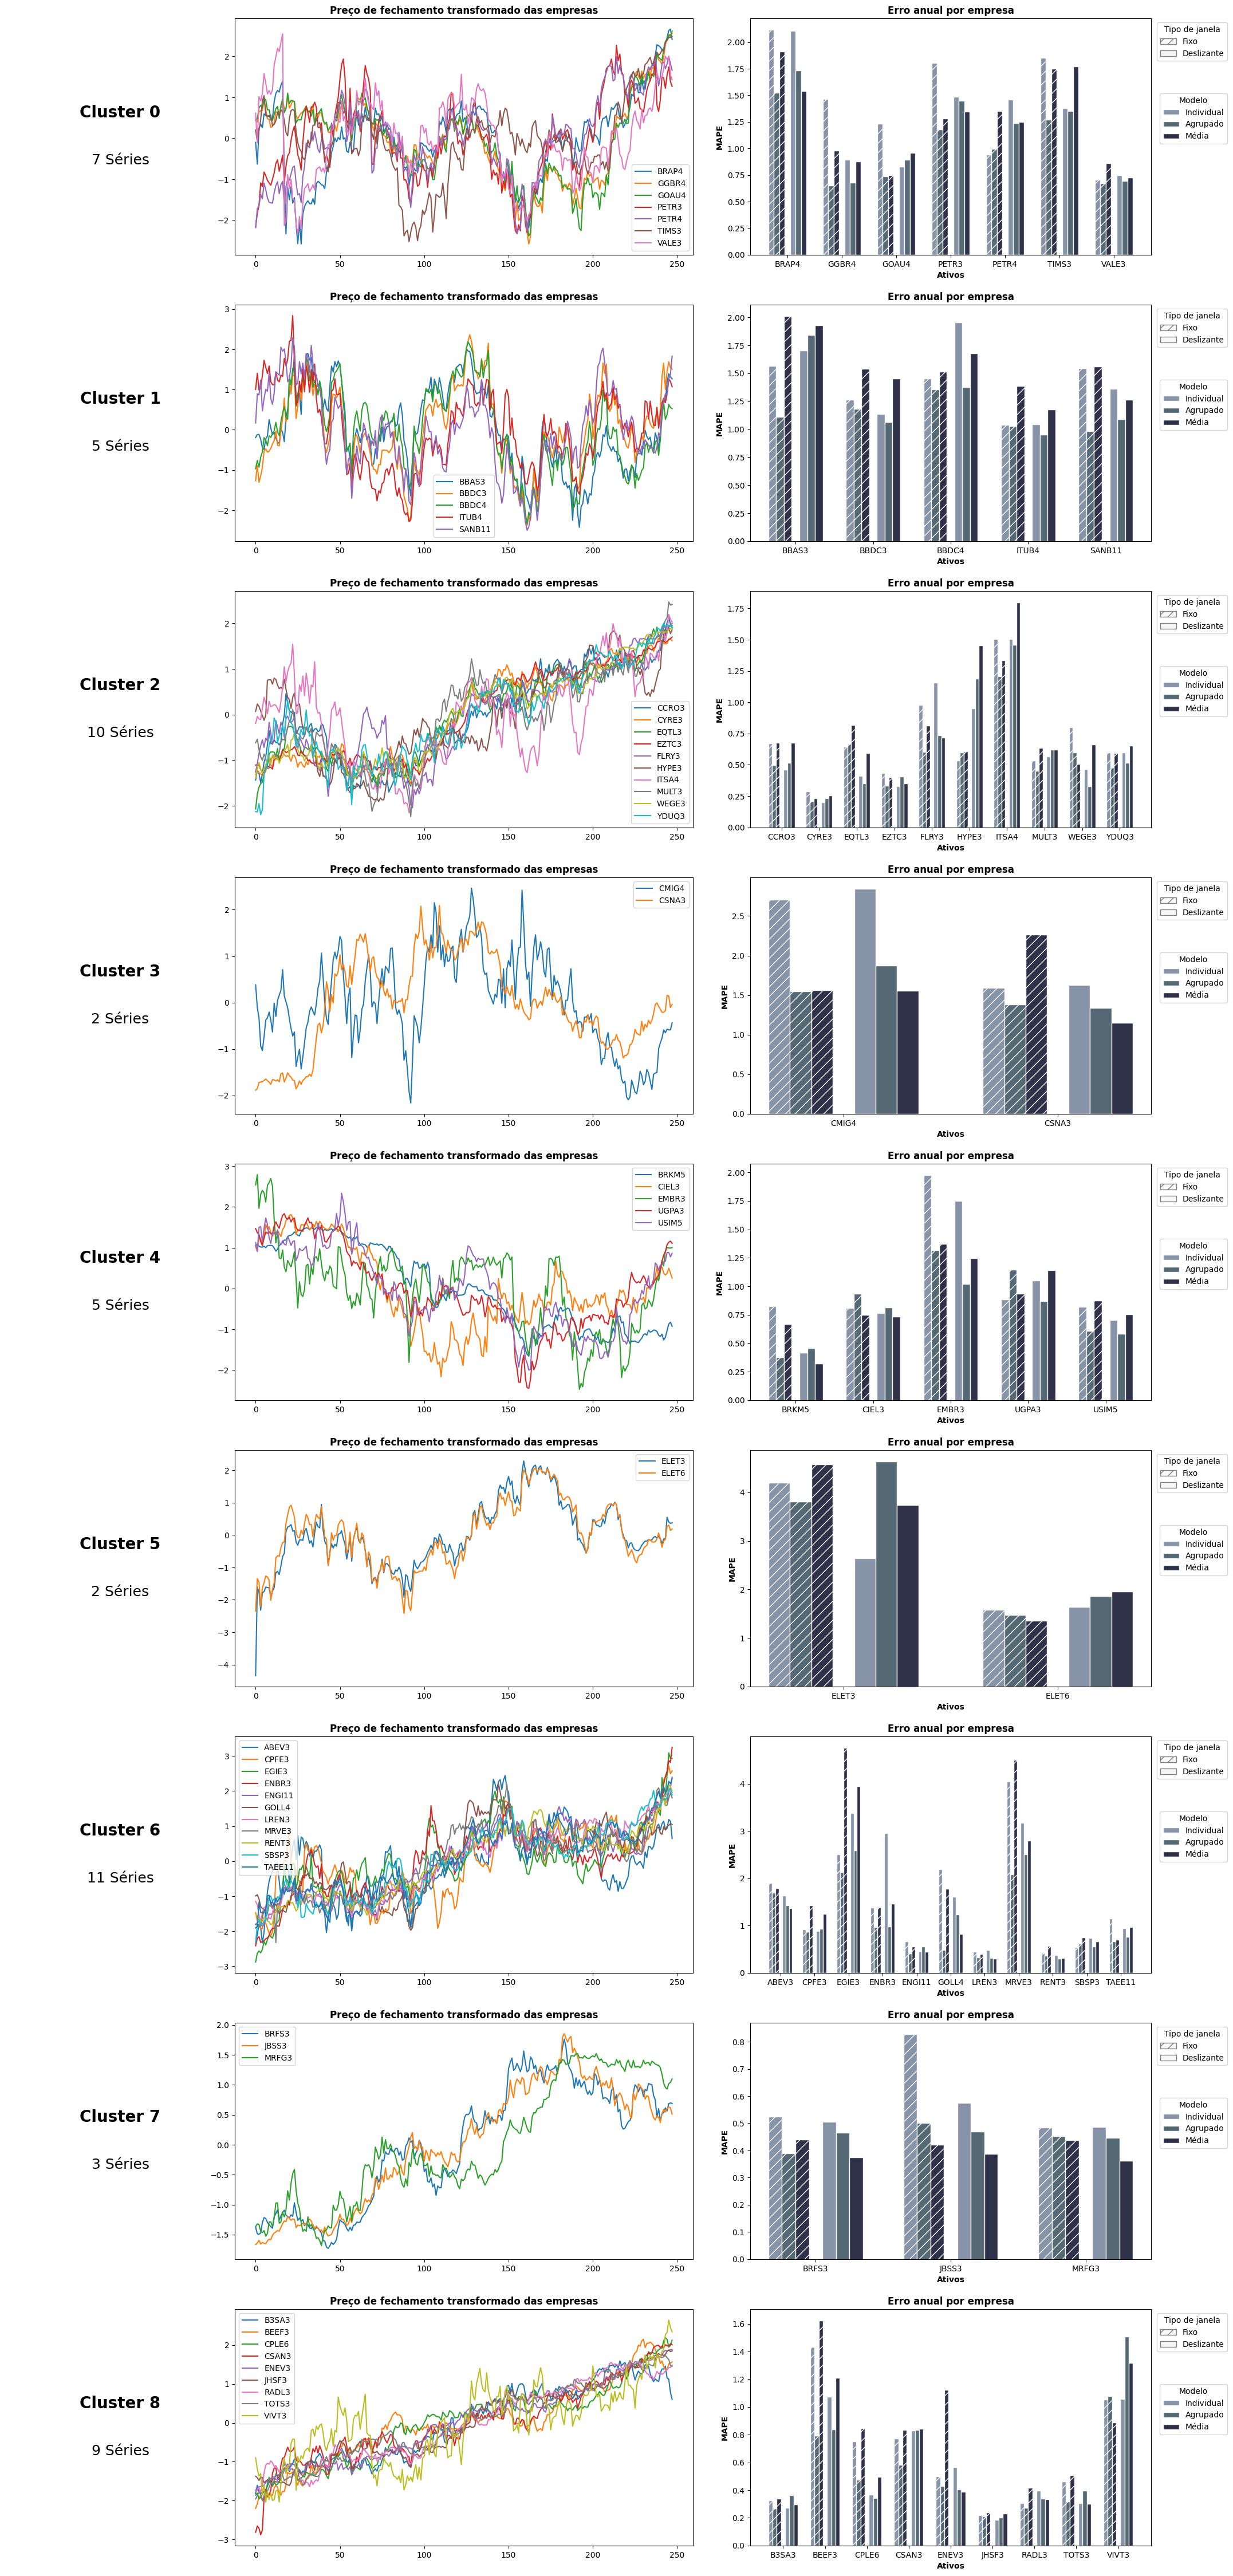

In [313]:
import matplotlib.pyplot as plt
import numpy as np

# Criar a figura
fig = plt.figure(figsize=(20, 25))


# Loop para criar 5 linhas de subgráficos
for i in range(9):
    # Altura de início para esta linha de subgráficos
    bottom = 1 - (i + 1) * 0.2 + 1
    
    # Adicionar o subplot para o valor numérico
    ax0 = label_cluster_plot(cluster=i, bottom=bottom)
    
    # Adicionar o subplot para o gráfico de linhas
    ax1 = series_cluster_plot (cluster=i, bottom=bottom)
    
    # Adicionar o subplot para o gráfico de barras
    ax2 = grafico_erro_cluster(resultado, cluster=i, bottom=bottom)
    

plt.show();


In [231]:
resultado = pd.read_excel('Resultado_fixo_deslizante.xlsx')

dados = pd.read_excel('../codigos/data/2019_t.xlsx')
classificacao = pd.read_excel('../codigos/resultados/2019/classes_nova.xlsx')

dados_media = pd.DataFrame()


for i in range(9):
  cluster_series = classificacao.query(f'classes=={i}')

  lista_valores = cluster_series['ativos']
  df_filtrado = resultado[resultado['Ativos'].isin(lista_valores)]
  df_filtrado.drop('Ativos',axis=1, inplace=True)
  
  dados_media[f'Cluster {i}'] = df_filtrado.mean().values

/tmp/ipykernel_13328/310210813.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado.drop('Ativos',axis=1, inplace=True)
/tmp/ipykernel_13328/310210813.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado.drop('Ativos',axis=1, inplace=True)
/tmp/ipykernel_13328/310210813.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado.drop('Ativos',axis=1, inplace=True)
/tmp/ipykernel_13328/310210813.py:14: Setti

In [232]:
dados_final = dados_media.T
dados_final.columns=resultado.columns[1:]

In [233]:
dados_final.insert(0, 'i', 0)

In [234]:
dados_final

,i,1 Individual fixo,1 Individual deslizante,1 Agrupado fixo,1 Agrupado deslizante,1 Media fixo,1 Media deslizante,2 Individual fixo,2 Individual deslizante,2 Agrupado fixo,...,11 Agrupado fixo,11 Agrupado deslizante,11 Media fixo,11 Media deslizante,12 Individual fixo,12 Individual deslizante,12 Agrupado fixo,12 Agrupado deslizante,12 Media fixo,12 Media deslizante
Cluster 0,0,0.797321,1.572804,0.602148,2.077387,0.636314,1.572257,0.993390,0.933409,0.847556,...,0.618807,0.798089,0.791268,0.813511,0.303382,0.215649,0.182606,0.154058,0.236506,0.161649
Cluster 1,0,1.796742,3.969671,1.357862,2.351070,2.178665,3.825370,0.626914,0.608842,0.546965,...,1.717946,1.441669,2.157912,1.823263,1.002225,0.780036,0.963597,0.942708,1.171983,1.202965
Cluster 2,0,1.105332,2.164853,0.820982,2.750718,1.361956,3.582170,0.779119,0.883036,0.813493,...,0.102387,0.119493,0.114419,0.100815,0.184371,0.106239,0.120571,0.079181,0.165329,0.138848
Cluster 3,0,2.952411,5.497651,2.729986,3.901515,2.179447,2.648204,0.962526,1.089098,0.608471,...,0.209860,0.111889,0.287544,0.148334,1.789897,1.566274,0.949527,0.967402,2.890724,0.626572
Cluster 4,0,0.438816,0.292200,0.297406,0.207720,0.550673,0.214001,0.420929,0.324063,0.333839,...,0.700479,0.399409,0.679662,0.665182,1.526804,1.518806,1.669097,1.105187,1.822248,1.624976
Cluster 5,0,0.862418,1.098795,0.858198,0.800120,0.962857,1.021100,1.840965,2.493163,2.035096,...,13.718171,11.409125,14.440462,7.311941,1.379726,1.356793,1.904931,1.069717,1.526348,1.098532
Cluster 6,0,1.161753,1.302236,0.834862,1.088428,0.617499,1.317257,0.653364,0.598192,0.506583,...,0.713903,0.782101,1.370780,0.958815,0.223023,0.193557,0.163964,0.198226,0.190632,0.152363
Cluster 7,0,0.516932,0.706204,0.306257,0.642638,0.269672,0.421535,0.321139,0.300345,0.124175,...,0.200474,0.169827,0.271743,0.187408,0.199562,0.176981,0.173458,0.185806,0.248933,0.149023
Cluster 8,0,0.356156,0.699891,0.266490,0.979547,0.298457,0.526943,0.336003,0.251220,0.220377,...,0.122423,0.300151,0.129449,0.086416,0.189961,0.089768,0.082023,0.054869,0.133535,0.079970


In [ ]:
resultado

In [12]:
i = 0
Individual = [resultado.iloc[i][[1,7,13,19,25,31,37,43,49,55,61,67]].mean(), resultado.iloc[i][[2,8,14,20,26,32,38,44,50,56,62,68]].mean()]
Agrupado = [resultado.iloc[i][[3,9,15,21,27,33,39,45,51,57,63,69]].mean(), resultado.iloc[i][[4,10,16,22,28,34,40,46,52,58,64,70]].mean()]
Media = [resultado.iloc[i][[5,11,17,23,29,35,41,47,53,59,65,71]].mean(), resultado.iloc[i][[6,12,18,24,30,36,42,48,54,60,66,72]].mean()]

In [24]:
resultado.iloc[[0,1]]

,Ativos,1 Individual fixo,1 Individual deslizante,1 Agrupado fixo,1 Agrupado deslizante,1 Media fixo,1 Media deslizante,2 Individual fixo,2 Individual deslizante,2 Agrupado fixo,...,11 Agrupado fixo,11 Agrupado deslizante,11 Media fixo,11 Media deslizante,12 Individual fixo,12 Individual deslizante,12 Agrupado fixo,12 Agrupado deslizante,12 Media fixo,12 Media deslizante
0,ABEV3,3.181050,1.978033,1.226508,1.702243,0.901485,1.598882,1.087269,1.524238,1.157799,...,3.025232,3.212881,4.753246,2.500480,0.360926,0.276175,0.420764,0.233452,0.278065,0.390651
1,B3SA3,0.302407,0.615839,0.289512,1.411510,0.379135,0.544821,0.178384,0.196360,0.141082,...,0.087927,0.286796,0.118885,0.066236,0.137200,0.145590,0.107183,0.130451,0.158971,0.161130


In [211]:
tick_positions

[0.3, 1.3, 2.3]

In [213]:
r2

[2.4, 2.5, 2.6]

In [286]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches


def grafico_erro_cluster(dados, cluster):

    classificacao = pd.read_excel('../codigos/resultados/2019/classes_nova.xlsx')
    cluster_series = classificacao.query(f'classes=={cluster}')


    # Parâmetros do gráfico
    num_ativos = len(dados)
    num_features = len(dados.columns)
    barWidth = 0.1
    features = dados.columns

    # Criando o plot
    fig, ax = plt.subplots(figsize=(7, 5))

    # Definindo a posição das barras
    r = np.arange(len(dados.index))

    # Plotando as barras para cada ativo
    r2=[0]
    tick_positions = []

    resultado_cluster = resultado[resultado['Ativos'].isin(cluster_series['ativos'])]
    for i, ativo in enumerate(resultado_cluster['Ativos']):
        
        resultados_ativo = resultado_cluster.query(f'Ativos=="{ativo}"')
        
        
        
        Individual = [resultados_ativo.iloc[0][[1,7,13,19,25,31,37,43,49,55,61,67]].mean(), resultados_ativo.iloc[0][[2,8,14,20,26,32,38,44,50,56,62,68]].mean()]
        Agrupado = [resultados_ativo.iloc[0][[3,9,15,21,27,33,39,45,51,57,63,69]].mean(), resultados_ativo.iloc[0][[4,10,16,22,28,34,40,46,52,58,64,70]].mean()]
        Media = [resultados_ativo.iloc[0][[5,11,17,23,29,35,41,47,53,59,65,71]].mean(), resultados_ativo.iloc[0][[6,12,18,24,30,36,42,48,54,60,66,72]].mean()]


        first_group = [Individual[0], Agrupado[0], Media[0]]
        second_group = [Individual[1], Agrupado[1], Media[1]]
        
        inicio = 0 if i == 0 else 0.4
        r1 = [r2[-1] + inicio + x for x in np.arange(0,0.3,0.1)]
        r2 = [r1[-3] + x +0.1 for x in np.arange(0.3,0.6,0.1)]


        ax.bar(r1, first_group, color=['#8793a6', '#546973', '#2e3148'], width=barWidth, edgecolor='#f7f7f7', hatch='//')
        
        ax.bar(r2, second_group, color=['#8793a6', '#546973', '#2e3148'], width=barWidth, edgecolor='#f7f7f7')
        
        # Calcular as posições dos ticks com base na posição das barras
        tick_positions.append((r1[0] + r2[-1]) / 2)
        
    # Definir as posições dos ticks
    ax.set_xticks(tick_positions)

    # Definir os rótulos dos ticks
    ax.set_xticklabels(resultado_cluster['Ativos'])

    handle3 = patches.Rectangle((0, 0), 1, 1, facecolor="#8793a6", edgecolor="#f7f7f7", label="Individual")
    handle4 = patches.Rectangle((0, 0), 1, 1, facecolor="#546973", edgecolor="#f7f7f7", label="Agrupado")
    handle5 = patches.Rectangle((0, 0), 1, 1, facecolor="#2e3148", edgecolor="#f7f7f7", label="Média")

    legend2 = ax.legend(handles=[handle3, handle4, handle5], bbox_to_anchor=(1, 0.7), title='Modelo')
    ax.add_artist(legend2)


    # Criando handles para as legendas
    handle1 = patches.Rectangle((0, 0), 1, 1, facecolor="#f7f7f7", edgecolor="gray", hatch="//", label="Fixo")
    handle2 = patches.Rectangle((0, 0), 1, 1, facecolor="#f7f7f7", edgecolor="gray", label="Deslizante")
    ax.legend(handles=[handle1, handle2], bbox_to_anchor=(1, 1), title='Tipo de janela')


    # Configurando o título e rótulos dos eixos
    ax.set_title('Erro anual por empresa', fontweight='bold')
    ax.set_xlabel('Ativos', fontweight='bold')
    ax.set_ylabel('MAPE', fontweight='bold')

    # Exibindo o gráfico
    plt.tight_layout()
    plt.show();


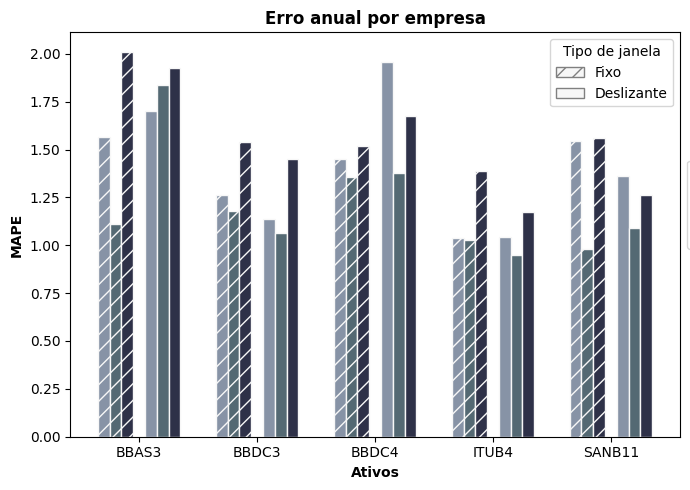

In [288]:
grafico_erro_cluster(resultado, 1)